In [1]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp

In [2]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_hands = mp.solutions.hands

In [3]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [4]:
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION) # Draw face connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connections

In [5]:
def draw_styled_landmarks(image, results):
    # Draw face connections
    #mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION, 
    #                         mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
    #                         mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
    #                         ) 
    # Draw pose connections
    #mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
    #                         mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
    #                         mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
    #                         ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             )

In [6]:
def draw_styled_hand_landmarks(image, results):
    for hand_landmarks in results.multi_hand_landmarks:
                  mp_drawing.draw_landmarks(
                      image,
                      hand_landmarks,
                      mp_hands.HAND_CONNECTIONS,
                      mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                      mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2))

In [7]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([lh, rh])

In [8]:
def extract_hand_keypoints(results):
    lh = [[res.x, res.y, res.z] for res in results.left_hand_landmarks[0].landmark] if results.left_hand_landmarks else [[0]*3]*21
    rh = [[res.x, res.y, res.z] for res in results.right_hand_landmarks[1].landmark] if results.right_hand_landmarks else [[0]*3]*21
    return np.vstack((lh,rh))

In [9]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=512)])
  except RuntimeError as e:
    print(e)

In [10]:
# Path for exported data, numpy arrays
# Step 4
DATA_PATH = os.path.join('ISL_Data')
actions = np.array(['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z'])
#actions = np.array(['A','B'])

# no of images
no_sequences = 30

# no of frames in each video
sequence_length = 30

In [11]:
# Step 6 - preprocess data create labels and features
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [12]:
label_map = {label:num for num, label in enumerate(actions)}
label_map

{'A': 0,
 'B': 1,
 'C': 2,
 'D': 3,
 'E': 4,
 'F': 5,
 'G': 6,
 'H': 7,
 'I': 8,
 'J': 9,
 'K': 10,
 'L': 11,
 'M': 12,
 'N': 13,
 'O': 14,
 'P': 15,
 'Q': 16,
 'R': 17,
 'S': 18,
 'T': 19,
 'U': 20,
 'V': 21,
 'W': 22,
 'X': 23,
 'Y': 24,
 'Z': 25}

In [13]:
sequences, labels = [], []
for action in actions:
    for sequence in range(no_sequences):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [14]:
X = np.array(sequences)
y = to_categorical(labels).astype(int)

In [15]:
len(X)

780

In [16]:
len(y)

780

In [17]:
X = X.reshape((X.shape[0], X.shape[1], 42, 3))

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [19]:
X_train.shape

(624, 30, 42, 3)

In [20]:
X_test.shape

(156, 30, 42, 3)

In [21]:
y_train.shape

(624, 26)

In [22]:
y_test.shape

(156, 26)

In [23]:
# Step 7 - build and train lSTM NN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Conv2D, MaxPool2D, Flatten, Dropout
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping

In [24]:
# Before running this, delete the Logs folder
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [25]:
from keras.models import load_model
#model = load_model('weights_benchmark.h5')

In [92]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding = 'same', input_shape=X_train.shape[1:]))
model.add(MaxPool2D(pool_size=(2,2), strides=None))

model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=None))

model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding = 'valid'))
model.add(Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding = 'valid'))

model.add(MaxPool2D(pool_size=(2,2), strides=None))

# model.add(MaxPool2D(pool_size=(2,2), strides=None))
# #model.add(MaxPool1D(pool_size=3, strides=None))



model.add(Flatten())

model.add(Dense(128,activation ="relu"))
model.add(Dropout(0.2))
model.add(Dense(64,activation ="relu"))
model.add(Dropout(0.2))
#model.add(Dense(128,activation ="relu"))
#model.add(Dropout(0.2))
#model.add(Dense(128,activation ="relu"))
#model.add(Dropout(0.3))
model.add(Dense(actions.shape[0],activation ="softmax"))

In [93]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_44 (Conv2D)          (None, 30, 42, 32)        896       
                                                                 
 max_pooling2d_33 (MaxPoolin  (None, 15, 21, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_45 (Conv2D)          (None, 13, 19, 64)        18496     
                                                                 
 max_pooling2d_34 (MaxPoolin  (None, 6, 9, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_46 (Conv2D)          (None, 4, 7, 128)         73856     
                                                                 
 conv2d_47 (Conv2D)          (None, 2, 5, 256)       

In [94]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [95]:
history = model.fit(X_train, y_train, validation_split=0.2, epochs=500)

Epoch 1/500
16/16 [==============================] - 1s 31ms/step - loss: 3.2475 - categorical_accuracy: 0.0521 - val_loss: 3.2122 - val_categorical_accuracy: 0.0560
Epoch 2/500
16/16 [==============================] - 0s 21ms/step - loss: 3.1092 - categorical_accuracy: 0.0581 - val_loss: 3.0203 - val_categorical_accuracy: 0.1120
Epoch 3/500
16/16 [==============================] - 0s 20ms/step - loss: 2.8986 - categorical_accuracy: 0.1283 - val_loss: 2.7467 - val_categorical_accuracy: 0.1600
Epoch 4/500
16/16 [==============================] - 0s 21ms/step - loss: 2.7108 - categorical_accuracy: 0.1663 - val_loss: 2.6040 - val_categorical_accuracy: 0.1840
Epoch 5/500
16/16 [==============================] - 0s 20ms/step - loss: 2.4825 - categorical_accuracy: 0.2184 - val_loss: 2.2615 - val_categorical_accuracy: 0.2720
Epoch 6/500
16/16 [==============================] - 0s 20ms/step - loss: 2.3307 - categorical_accuracy: 0.2705 - val_loss: 2.2400 - val_categorical_accuracy: 0.2800
Epoc

16/16 [==============================] - 0s 25ms/step - loss: 0.0431 - categorical_accuracy: 0.9820 - val_loss: 0.4397 - val_categorical_accuracy: 0.9040
Epoch 100/500
16/16 [==============================] - 0s 23ms/step - loss: 0.0473 - categorical_accuracy: 0.9880 - val_loss: 0.6652 - val_categorical_accuracy: 0.8880
Epoch 101/500
16/16 [==============================] - 0s 23ms/step - loss: 0.0962 - categorical_accuracy: 0.9659 - val_loss: 0.5361 - val_categorical_accuracy: 0.8960
Epoch 102/500
16/16 [==============================] - 0s 23ms/step - loss: 0.0635 - categorical_accuracy: 0.9800 - val_loss: 0.5507 - val_categorical_accuracy: 0.9040
Epoch 103/500
16/16 [==============================] - 0s 23ms/step - loss: 0.0756 - categorical_accuracy: 0.9760 - val_loss: 0.5048 - val_categorical_accuracy: 0.8720
Epoch 104/500
16/16 [==============================] - 0s 24ms/step - loss: 0.1486 - categorical_accuracy: 0.9659 - val_loss: 0.5270 - val_categorical_accuracy: 0.8640
Epoch 

Epoch 148/500
16/16 [==============================] - 0s 23ms/step - loss: 0.0399 - categorical_accuracy: 0.9900 - val_loss: 0.3072 - val_categorical_accuracy: 0.9200
Epoch 149/500
16/16 [==============================] - 0s 21ms/step - loss: 0.0424 - categorical_accuracy: 0.9880 - val_loss: 0.6761 - val_categorical_accuracy: 0.8960
Epoch 150/500
16/16 [==============================] - 0s 21ms/step - loss: 0.0233 - categorical_accuracy: 0.9920 - val_loss: 0.6400 - val_categorical_accuracy: 0.8800
Epoch 151/500
16/16 [==============================] - 0s 22ms/step - loss: 0.0204 - categorical_accuracy: 0.9920 - val_loss: 0.3635 - val_categorical_accuracy: 0.9280
Epoch 152/500
16/16 [==============================] - 0s 21ms/step - loss: 0.0143 - categorical_accuracy: 0.9980 - val_loss: 0.5007 - val_categorical_accuracy: 0.9200
Epoch 153/500
16/16 [==============================] - 0s 21ms/step - loss: 0.0201 - categorical_accuracy: 0.9900 - val_loss: 0.4654 - val_categorical_accuracy:

Epoch 197/500
16/16 [==============================] - 0s 24ms/step - loss: 0.0332 - categorical_accuracy: 0.9960 - val_loss: 0.3075 - val_categorical_accuracy: 0.9360
Epoch 198/500
16/16 [==============================] - 0s 23ms/step - loss: 0.0090 - categorical_accuracy: 0.9980 - val_loss: 0.1987 - val_categorical_accuracy: 0.9520
Epoch 199/500
16/16 [==============================] - 0s 23ms/step - loss: 0.0211 - categorical_accuracy: 0.9980 - val_loss: 0.1726 - val_categorical_accuracy: 0.9600
Epoch 200/500
16/16 [==============================] - 0s 23ms/step - loss: 0.0170 - categorical_accuracy: 0.9980 - val_loss: 0.2369 - val_categorical_accuracy: 0.9520
Epoch 201/500
16/16 [==============================] - 0s 23ms/step - loss: 0.0125 - categorical_accuracy: 0.9940 - val_loss: 0.3368 - val_categorical_accuracy: 0.9360
Epoch 202/500
16/16 [==============================] - 0s 23ms/step - loss: 0.0066 - categorical_accuracy: 0.9980 - val_loss: 0.3961 - val_categorical_accuracy:

Epoch 246/500
16/16 [==============================] - 0s 23ms/step - loss: 0.1209 - categorical_accuracy: 0.9639 - val_loss: 0.4855 - val_categorical_accuracy: 0.8640
Epoch 247/500
16/16 [==============================] - 0s 24ms/step - loss: 0.1196 - categorical_accuracy: 0.9719 - val_loss: 0.4927 - val_categorical_accuracy: 0.8880
Epoch 248/500
16/16 [==============================] - 0s 23ms/step - loss: 0.1161 - categorical_accuracy: 0.9760 - val_loss: 0.6586 - val_categorical_accuracy: 0.8960
Epoch 249/500
16/16 [==============================] - 0s 23ms/step - loss: 0.0586 - categorical_accuracy: 0.9840 - val_loss: 0.3657 - val_categorical_accuracy: 0.9280
Epoch 250/500
16/16 [==============================] - 0s 23ms/step - loss: 0.0517 - categorical_accuracy: 0.9920 - val_loss: 0.2385 - val_categorical_accuracy: 0.9360
Epoch 251/500
16/16 [==============================] - 0s 23ms/step - loss: 0.0185 - categorical_accuracy: 0.9920 - val_loss: 0.2578 - val_categorical_accuracy:

Epoch 295/500
16/16 [==============================] - 0s 23ms/step - loss: 0.0040 - categorical_accuracy: 0.9980 - val_loss: 0.3185 - val_categorical_accuracy: 0.9280
Epoch 296/500
16/16 [==============================] - 0s 23ms/step - loss: 0.0041 - categorical_accuracy: 1.0000 - val_loss: 0.3143 - val_categorical_accuracy: 0.9120
Epoch 297/500
16/16 [==============================] - 0s 23ms/step - loss: 0.0014 - categorical_accuracy: 1.0000 - val_loss: 0.3346 - val_categorical_accuracy: 0.9200
Epoch 298/500
16/16 [==============================] - 0s 23ms/step - loss: 0.0150 - categorical_accuracy: 0.9940 - val_loss: 0.3414 - val_categorical_accuracy: 0.9200
Epoch 299/500
16/16 [==============================] - 0s 23ms/step - loss: 0.0709 - categorical_accuracy: 0.9860 - val_loss: 0.4290 - val_categorical_accuracy: 0.9040
Epoch 300/500
16/16 [==============================] - 0s 23ms/step - loss: 0.0769 - categorical_accuracy: 0.9699 - val_loss: 0.3110 - val_categorical_accuracy:

Epoch 344/500
16/16 [==============================] - 0s 23ms/step - loss: 0.0015 - categorical_accuracy: 1.0000 - val_loss: 0.3662 - val_categorical_accuracy: 0.9440
Epoch 345/500
16/16 [==============================] - 0s 23ms/step - loss: 0.0027 - categorical_accuracy: 0.9980 - val_loss: 0.3696 - val_categorical_accuracy: 0.9520
Epoch 346/500
16/16 [==============================] - 0s 23ms/step - loss: 7.7031e-04 - categorical_accuracy: 1.0000 - val_loss: 0.3788 - val_categorical_accuracy: 0.9520
Epoch 347/500
16/16 [==============================] - 0s 23ms/step - loss: 0.0014 - categorical_accuracy: 1.0000 - val_loss: 0.3952 - val_categorical_accuracy: 0.9520
Epoch 348/500
16/16 [==============================] - 0s 23ms/step - loss: 0.0029 - categorical_accuracy: 0.9980 - val_loss: 0.4188 - val_categorical_accuracy: 0.9360
Epoch 349/500
16/16 [==============================] - 0s 24ms/step - loss: 0.0028 - categorical_accuracy: 0.9980 - val_loss: 0.6336 - val_categorical_accur

16/16 [==============================] - 0s 24ms/step - loss: 0.0038 - categorical_accuracy: 0.9980 - val_loss: 0.2979 - val_categorical_accuracy: 0.9360
Epoch 441/500
16/16 [==============================] - 0s 24ms/step - loss: 0.0025 - categorical_accuracy: 1.0000 - val_loss: 0.4077 - val_categorical_accuracy: 0.9280
Epoch 442/500
16/16 [==============================] - 0s 24ms/step - loss: 0.0082 - categorical_accuracy: 0.9940 - val_loss: 0.2693 - val_categorical_accuracy: 0.9520
Epoch 443/500
16/16 [==============================] - 0s 24ms/step - loss: 0.0131 - categorical_accuracy: 0.9940 - val_loss: 0.3831 - val_categorical_accuracy: 0.9360
Epoch 444/500
16/16 [==============================] - 0s 24ms/step - loss: 0.0091 - categorical_accuracy: 0.9960 - val_loss: 0.2770 - val_categorical_accuracy: 0.9440
Epoch 445/500
16/16 [==============================] - 0s 24ms/step - loss: 0.0019 - categorical_accuracy: 1.0000 - val_loss: 0.2593 - val_categorical_accuracy: 0.9440
Epoch 

In [96]:
from sklearn.metrics import multilabel_confusion_matrix, confusion_matrix, accuracy_score, precision_recall_fscore_support
yhat = model.predict(X_test)
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

print("Accuracy Score: {}".format(accuracy_score(ytrue, yhat)))

Accuracy Score: 0.9358974358974359


In [97]:
print(history.history.keys())

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])


In [98]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_44 (Conv2D)          (None, 30, 42, 32)        896       
                                                                 
 max_pooling2d_33 (MaxPoolin  (None, 15, 21, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_45 (Conv2D)          (None, 13, 19, 64)        18496     
                                                                 
 max_pooling2d_34 (MaxPoolin  (None, 6, 9, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_46 (Conv2D)          (None, 4, 7, 128)         73856     
                                                                 
 conv2d_47 (Conv2D)          (None, 2, 5, 256)       

In [99]:
len(history.history['categorical_accuracy'])

500

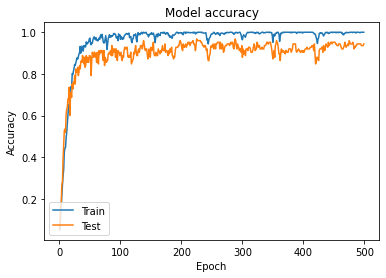

In [101]:
# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower left')
#plt.show()
plt.savefig('accuracy_custom.pdf', dpi = 700)

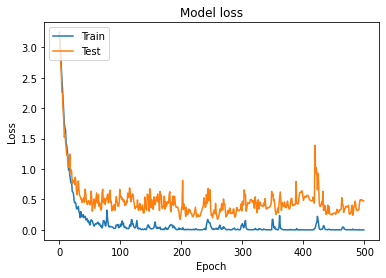

In [102]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
#plt.show()
plt.savefig('loss_custom.pdf', dpi = 700)

In [ ]:
! pip install pydot

In [103]:
from tensorflow.keras.utils import plot_model

#model = ResNet50(weights='imagenet')
plot_model(model, to_file='model_custom.pdf', dpi = 700, show_shapes=True)

In [104]:
# Step 8 - Make prediction
res = model.predict(X_test)

In [105]:
actions[np.argmax(res[0])]

'T'

In [106]:
actions[np.argmax(y_test[0])]

'T'

In [107]:
from sklearn.metrics import multilabel_confusion_matrix, confusion_matrix, accuracy_score, precision_recall_fscore_support

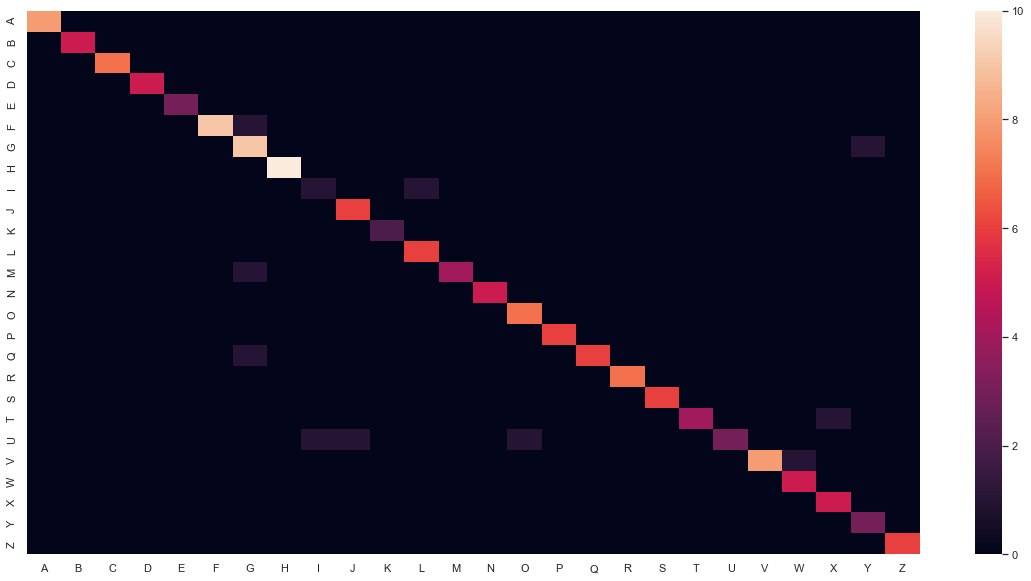

In [108]:
import seaborn as sns
yhat = model.predict(X_test)
ytrue = np.argmax(y_test, axis=1)
yhat = np.argmax(yhat, axis=1)

cf_matr = confusion_matrix(ytrue, yhat)
sns.set(rc = {'figure.figsize':(20, 10)})
hmap = sns.heatmap(cf_matr,xticklabels=actions,yticklabels=actions)
hmap
figure = hmap.get_figure()  
#figure
#figure.savefig('Confusion_matrix.pdf', dpi=700)

In [109]:
from sklearn.metrics import fbeta_score 
(precision, recall, f1_score, _) = precision_recall_fscore_support(ytrue, yhat, average='macro')
print("Precision Score: {}\nRecall Score: {}\nF1 Score: {}".format(precision, recall, f1_score))
print("F Beta Score for Beta as 0.5 = {}".format(fbeta_score(ytrue, yhat, average='macro', beta=0.5)))

Precision Score: 0.9329212454212455
Recall Score: 0.9286935286935287
F1 Score: 0.9241946127752272
F Beta Score for Beta as 0.5 = 0.9273585870477405


In [110]:
from sklearn.metrics import classification_report
print(classification_report(ytrue, yhat, target_names=actions))

              precision    recall  f1-score   support

           A       1.00      1.00      1.00         8
           B       1.00      1.00      1.00         5
           C       1.00      1.00      1.00         7
           D       1.00      1.00      1.00         5
           E       1.00      1.00      1.00         3
           F       1.00      0.90      0.95        10
           G       0.75      0.90      0.82        10
           H       1.00      1.00      1.00        10
           I       0.50      0.50      0.50         2
           J       0.86      1.00      0.92         6
           K       1.00      1.00      1.00         2
           L       0.86      1.00      0.92         6
           M       1.00      0.80      0.89         5
           N       1.00      1.00      1.00         5
           O       0.88      1.00      0.93         7
           P       1.00      1.00      1.00         6
           Q       1.00      0.86      0.92         7
           R       1.00    

In [111]:
from sklearn.metrics import hamming_loss
print("Hamming Loss: {}".format(hamming_loss(ytrue, yhat)))

Hamming Loss: 0.0641025641025641


In [112]:
from sklearn.metrics import jaccard_score, matthews_corrcoef
print("Jaccard Score: {}".format(jaccard_score(ytrue, yhat, average='macro')))
print("Matthews correlation coefficient: {}".format(matthews_corrcoef(ytrue, yhat)))

Jaccard Score: 0.8760625058701983
Matthews correlation coefficient: 0.9334709474777175


In [113]:
import pandas as pd
import matplotlib.pyplot as plt


def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    axes.set_ylabel('True label')
    axes.set_xlabel('Predicted label')
    axes.set_title("Confusion Matrix for the class - " + class_label)

In [114]:
actions[12:]

array(['M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y',
       'Z'], dtype='<U1')

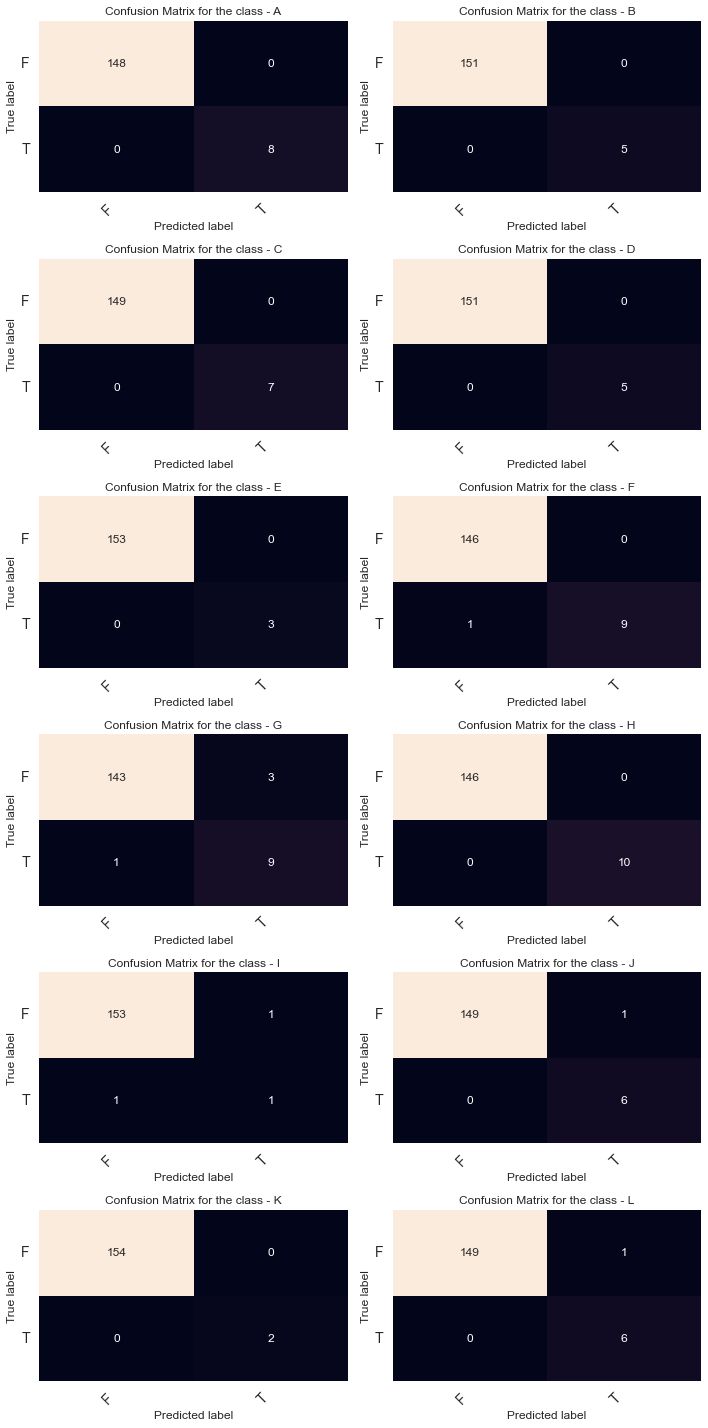

In [115]:
fig, ax = plt.subplots(6, 2, figsize=(10, 20))
conf_matrix = multilabel_confusion_matrix(ytrue, yhat)
    
for axes, cfs_matrix, label in zip(ax.flatten(), conf_matrix[0:12], actions[0:12]):
    print_confusion_matrix(cfs_matrix, axes, label, ["F", "T"])

fig.tight_layout()
plt.show()
#plt.savefig('conf_mat.pdf', dpi = 700)

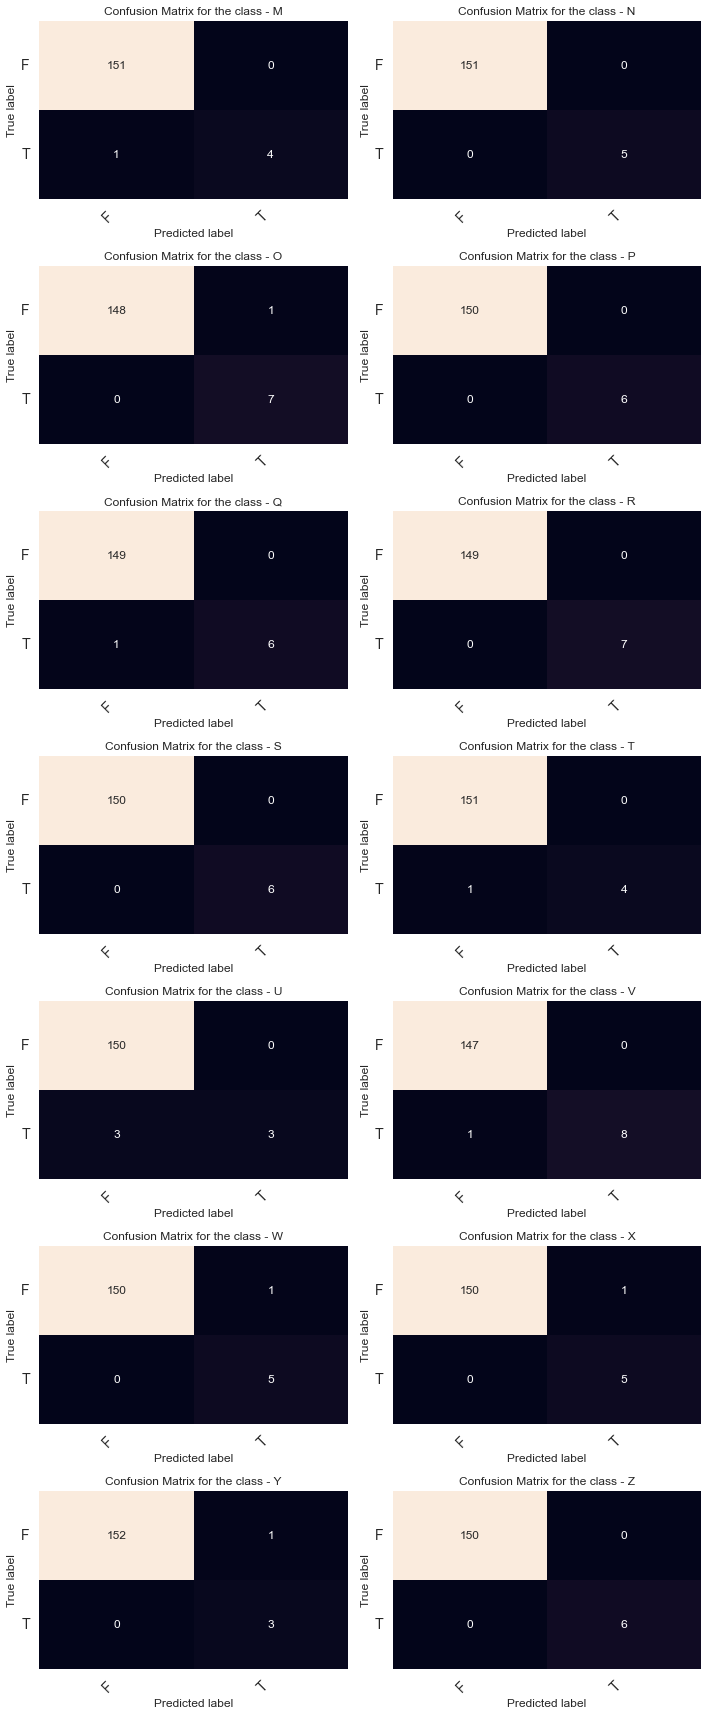

In [116]:
fig, ax = plt.subplots(7, 2, figsize=(10, 24))
    
for axes, cfs_matrix, label in zip(ax.flatten(), conf_matrix[12:], actions[12:]):
    print_confusion_matrix(cfs_matrix, axes, label, ["F", "T"])

fig.tight_layout()
plt.show()
#plt.savefig('conf_mat2.pdf', dpi = 700)

In [117]:
# Uncomment to save your model
model.save('weights_custom.h5')

In [118]:
# import tensorflow as tf
# import tensorflow_hub as hub
# from tensorflow import lite

# SAVED_MODEL = "saved_models"
# tf.saved_model.save(model, SAVED_MODEL)

In [119]:
# #sigmodel = hub.load(SAVED_MODEL)
# TFLITE_MODEL = "tflite_models/sign.tflite"
# TFLITE_QUANT_MODEL = "tflite_models/sign_quant.tflite"

In [120]:
# def convert_to_tflite():
#     converter = lite.TFLiteConverter.from_keras_model(model)

#     converter.optimizations = [tf.lite.Optimize.DEFAULT]
#     converter.experimental_new_converter = True
#     converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS,
#                                            tf.lite.OpsSet.SELECT_TF_OPS]

#     converted_tflite_model = converter.convert()
#     open(TFLITE_MODEL, "wb").write(converted_tflite_model)

#     converter = lite.TFLiteConverter.from_keras_model(model)
#     converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
#     converter.experimental_new_converter = True
#     converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS,
#                                            tf.lite.OpsSet.SELECT_TF_OPS]

#     tflite_quant_model = converter.convert()
#     open(TFLITE_QUANT_MODEL, "wb").write(tflite_quant_model)

In [121]:
#convert_to_tflite()

In [122]:
# def use_tflite(X_test, y_test):
#     X_test = np.float32(X_test)
#     y_test = np.float32(y_test)
    
#     tflite_interpreter = tf.lite.Interpreter(model_path=TFLITE_MODEL)

#     input_details = tflite_interpreter.get_input_details()
#     output_details = tflite_interpreter.get_output_details()

#     tflite_interpreter.resize_tensor_input(
#         input_details[0]['index'], X_test.shape)
#     tflite_interpreter.resize_tensor_input(
#         output_details[0]['index'], y_test.shape)
#     tflite_interpreter.allocate_tensors()

#     input_details = tflite_interpreter.get_input_details()
#     output_details = tflite_interpreter.get_output_details()

#     # Load quantized TFLite model
#     tflite_interpreter_quant = tf.lite.Interpreter(
#         model_path=TFLITE_QUANT_MODEL)

#     # Learn about its input and output details
#     input_details = tflite_interpreter_quant.get_input_details()
#     output_details = tflite_interpreter_quant.get_output_details()

#     # Resize input and output tensors
#     tflite_interpreter_quant.resize_tensor_input(
#         input_details[0]['index'], X_test.shape)
#     tflite_interpreter_quant.resize_tensor_input(
#         output_details[0]['index'], y_test.shape)
#     tflite_interpreter_quant.allocate_tensors()

#     input_details = tflite_interpreter_quant.get_input_details()
#     output_details = tflite_interpreter_quant.get_output_details()

#     # Run inference
#     tflite_interpreter_quant.set_tensor(input_details[0]['index'], X_test)

#     tflite_interpreter_quant.invoke()

#     tflite_q_model_predictions = tflite_interpreter_quant.get_tensor(
#         output_details[0]['index'])
# #print("\nPrediction results shape:", tflite_q_model_predictions.shape)

In [123]:
#use_tflite(X_test, y_test)

In [17]:
new_actions = np.array(['C', 'O'])
new_label_map = {label:num for num, label in enumerate(new_actions)}
new_label_map
sequence_length = 30

In [18]:
sequences, labels = [], []
for action in new_actions:
    for sequence in range(no_sequences):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(new_label_map[action])

In [19]:
X = np.array(sequences)

In [20]:
y = to_categorical(labels).astype(int)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [22]:
X_train.shape

(42, 30, 126)

In [23]:
y_train.shape

(42, 2)

In [24]:
from tensorflow.keras.layers import Conv1D, MaxPool1D

In [25]:
# CNN Model
model = Sequential()

model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=X_train.shape[1:]))
model.add(MaxPool1D(pool_size=2, strides=None))

model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding = 'same'))
model.add(MaxPool1D(pool_size=2, strides=None))

model.add(Conv1D(filters=128, kernel_size=3, activation='relu', padding = 'valid'))
model.add(MaxPool1D(pool_size=2, strides=None))

model.add(Flatten())

model.add(Dense(64,activation ="relu"))
model.add(Dropout(0.2))
model.add(Dense(128,activation ="relu"))
model.add(Dropout(0.3))
model.add(Dense(new_actions.shape[0],activation ="softmax"))

In [26]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [27]:
model.fit(X_train, y_train, epochs=100)

Epoch 1/100
2/2 [==============================] - 3s 178ms/step - loss: 0.6896 - categorical_accuracy: 0.5476
Epoch 2/100
2/2 [==============================] - 0s 16ms/step - loss: 0.6844 - categorical_accuracy: 0.6429
Epoch 3/100
2/2 [==============================] - 0s 12ms/step - loss: 0.6819 - categorical_accuracy: 0.6667
Epoch 4/100
2/2 [==============================] - 0s 16ms/step - loss: 0.6746 - categorical_accuracy: 0.5952
Epoch 5/100
2/2 [==============================] - 0s 11ms/step - loss: 0.6625 - categorical_accuracy: 0.6190
Epoch 6/100
2/2 [==============================] - 0s 15ms/step - loss: 0.6433 - categorical_accuracy: 0.7143
Epoch 7/100
2/2 [==============================] - 0s 14ms/step - loss: 0.6426 - categorical_accuracy: 0.6667
Epoch 8/100
2/2 [==============================] - 0s 15ms/step - loss: 0.6219 - categorical_accuracy: 0.6905
Epoch 9/100
2/2 [==============================] - 0s 16ms/step - loss: 0.5975 - categorical_accuracy: 0.7381
Epoch 10/

In [28]:
#model.summary()

In [29]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(model.predict(X_test), axis=1).tolist()
accuracy_score(ytrue, yhat)

1.0

In [30]:
model.save('models/actionCO.h5')

In [ ]:
# Step 8 - Make prediction
#res = model.predict(X_test)

In [ ]:
# yhat = model.predict(X_test)
# ytrue = np.argmax(y_test, axis=1)
# yhat = np.argmax(yhat, axis=1)

# cf_matr2 = confusion_matrix(ytrue, yhat)
# sns.set(rc = {'figure.figsize':(5, 4)})
# hmap2 = sns.heatmap(cf_matr2,xticklabels=new_actions,yticklabels=new_actions)
# hmap2
# figure = hmap2.get_figure()    
# figure.savefig('Confusion_matrixCO.pdf', dpi=700)

In [31]:
new_actions = np.array(['M', 'N'])
new_label_map = {label:num for num, label in enumerate(new_actions)}
new_label_map

{'M': 0, 'N': 1}

In [33]:
sequences, labels = [], []
for action in new_actions:
    for sequence in range(no_sequences):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(new_label_map[action])

In [34]:
X = np.array(sequences)

In [35]:
y = to_categorical(labels).astype(int)

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [37]:
X_train.shape

(42, 30, 126)

In [38]:
y_train.shape

(42, 2)

In [39]:
# # CNN Model
# model = Sequential()

# model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(30, 126)))
# model.add(MaxPool1D(pool_size=2, strides=None))

# model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding = 'same'))
# model.add(MaxPool1D(pool_size=2, strides=None))

# model.add(Conv1D(filters=128, kernel_size=3, activation='relu', padding = 'valid'))
# model.add(MaxPool1D(pool_size=2, strides=None))

# model.add(Flatten())

# model.add(Dense(64,activation ="relu"))
# model.add(Dropout(0.2))
# model.add(Dense(128,activation ="relu"))
# model.add(Dropout(0.3))
# model.add(Dense(new_actions.shape[0],activation ="softmax"))
model = load_model('models/actionCO.h5')

In [ ]:
# model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [40]:
model.fit(X_train, y_train, epochs=100)

Epoch 1/100
2/2 [==============================] - 0s 10ms/step - loss: 17.5158 - categorical_accuracy: 0.5000
Epoch 2/100
2/2 [==============================] - 0s 14ms/step - loss: 9.4832 - categorical_accuracy: 0.3333
Epoch 3/100
2/2 [==============================] - 0s 16ms/step - loss: 8.4171 - categorical_accuracy: 0.4524
Epoch 4/100
2/2 [==============================] - 0s 17ms/step - loss: 1.1600 - categorical_accuracy: 0.5476
Epoch 5/100
2/2 [==============================] - 0s 13ms/step - loss: 0.8707 - categorical_accuracy: 0.5000
Epoch 6/100
2/2 [==============================] - 0s 17ms/step - loss: 0.7409 - categorical_accuracy: 0.5000
Epoch 7/100
2/2 [==============================] - 0s 16ms/step - loss: 0.6991 - categorical_accuracy: 0.4286
Epoch 8/100
2/2 [==============================] - 0s 15ms/step - loss: 0.6881 - categorical_accuracy: 0.4286
Epoch 9/100
2/2 [==============================] - 0s 16ms/step - loss: 0.6986 - categorical_accuracy: 0.5000
Epoch 10/

In [42]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(model.predict(X_test), axis=1).tolist()
accuracy_score(ytrue, yhat)

1.0

In [43]:
# Uncomment to save your model
model.save('models/actionMN.h5')

In [ ]:
# Step 8 - Make prediction
#res = model.predict(X_test)

In [ ]:
# yhat = model.predict(X_test)
# ytrue = np.argmax(y_test, axis=1)
# yhat = np.argmax(yhat, axis=1)

# cf_matr3 = confusion_matrix(ytrue, yhat)
# sns.set(rc = {'figure.figsize':(5, 4)})
# hmap3 = sns.heatmap(cf_matr3,xticklabels=new_actions,yticklabels=new_actions)
# hmap3
# figure = hmap3.get_figure()    
# figure.savefig('Confusion_matrixMN.pdf', dpi=700)

In [ ]:
# yhat = model.predict(X_test)
# ytrue = np.argmax(y_test, axis=1).tolist()
# yhat = np.argmax(model.predict(X_test), axis=1).tolist()
# accuracy_score(ytrue, yhat)

In [ ]:
#plot_model(model, to_file='modelCO.pdf', dpi = 700, show_shapes=True)